In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
spark = SparkSession.builder.appName('summerRain').getOrCreate()

In [3]:
from io import StringIO
import itertools
import numpy as np
import pandas as pd
from pandas import Series
from pandas import concat
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(40,10))
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

<Figure size 2880x720 with 0 Axes>

In [4]:
%%time
def readFiles (feature):
    def process(tup):
        def convertTuple(tup): 
            str =  ''.join(tup) 
            return str

        # Driver code 
        str = convertTuple(tup[0:2]) 
        df = pd.read_csv(StringIO(str), header=None)

        # slicing the output and storing filename in "filename dataframe"
        filename = df[0:1]
        filename = filename.iloc[0][0].replace('txtncols         180','')
        filename = filename[-9:-1]

        # storing the content of file in "content dataframe"
        content = df[6:]

        counter = 0 
        allValues = 0

        # iterate through all the rows and columns of the file - better than for loop which took 40 mins
        modPandasDF=content.iloc[:,0].str.split(' ',expand=True).replace("-9999",float('NaN'))
        modPandasDF=modPandasDF.astype('float')
        modPandasDF=modPandasDF.values
        xDF=np.nanmean(modPandasDF)
        mean=np.nanmean(xDF)

        return filename, mean
    
    # daily grid data for rainfall
    if(feature=="rainfall" or feature=="maximum-temperature"):
        path = "hdfs:/data/HCP053/climate/gridded-land-obs-daily/grid/"+feature+"/*"
    elif(feature=="sunshine" or feature=="snow-falling"):
        path = "hdfs:/data/HCP053/climate/gridded-land-obs-monthly/"+feature+"/*"

    # Get rdd containing one record for each file.
    files_rdd = sc.wholeTextFiles(path, minPartitions=20)
    print(type(files_rdd))

    print('Number of records (months):', files_rdd.count())
    print('Number of partitions:', files_rdd.getNumPartitions())

    # map lines to n_words
    records = files_rdd.map(lambda n : process(n))

    # collect the RDD to a list
    llist = records.collect()

    # two arrays
    values = []
    months = []

    # store the filename in months array and its corrosponding value(mean) in values array
    for line in llist:
        values.append(line[1])
        months.append(line[0])

    # converting arrays to dataframes
    valuesdf = pd.DataFrame({'DailyMean':values[:]})
    yearmonthdf = pd.DataFrame({'YearMonth':months[:]})

    # merging two dataframes into one
    finaldf = pd.merge(yearmonthdf, valuesdf, left_index=True, right_index=True)

    # sort the index
    finaldf = finaldf.sort_values('YearMonth')

    # converting first column to integer format
    finaldf['YearMonth'] = finaldf['YearMonth'].astype('int')

    # converting first column from integer to datetime format
    finaldf['YearMonth'] = pd.to_datetime(finaldf['YearMonth'].astype(str), format='%Y%m%d')

    # extracting year and month 
    finaldf['Year'] = finaldf['YearMonth'].dt.year
    finaldf['Month'] = finaldf['YearMonth'].dt.month

    print(finaldf.head())
    
    return finaldf

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


<class 'pyspark.rdd.RDD'>
Number of records (months): 20820
Number of partitions: 20
       YearMonth  DailyMean  Year  Month
13541 1960-01-01   1.617598  1960      1
0     1960-01-02   1.112800  1960      1
9374  1960-01-03   3.992615  1960      1
1     1960-01-04   3.757235  1960      1
5208  1960-01-05   0.796998  1960      1


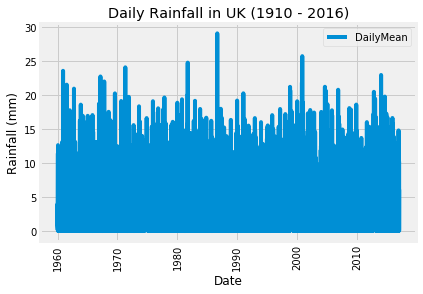

CPU times: user 519 ms, sys: 25.3 ms, total: 544 ms
Wall time: 3min 59s


In [5]:
%%time

finaldf = readFiles("rainfall")

finaldf.plot(x = 'YearMonth', y = 'DailyMean')
plt.title('Daily Rainfall in UK (1910 - 2016)')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.xticks(rotation='vertical')
plt.show()

# Observation from plot: just plotting daily rainfall vs years makes no sense as it is not possible to observe any trends

In [32]:
z=pd.DataFrame(finaldf['YearMonth'])
z.insert(1,'DailyMean',finaldf['DailyMean'])
z.to_csv('SGD1.csv', index=False)

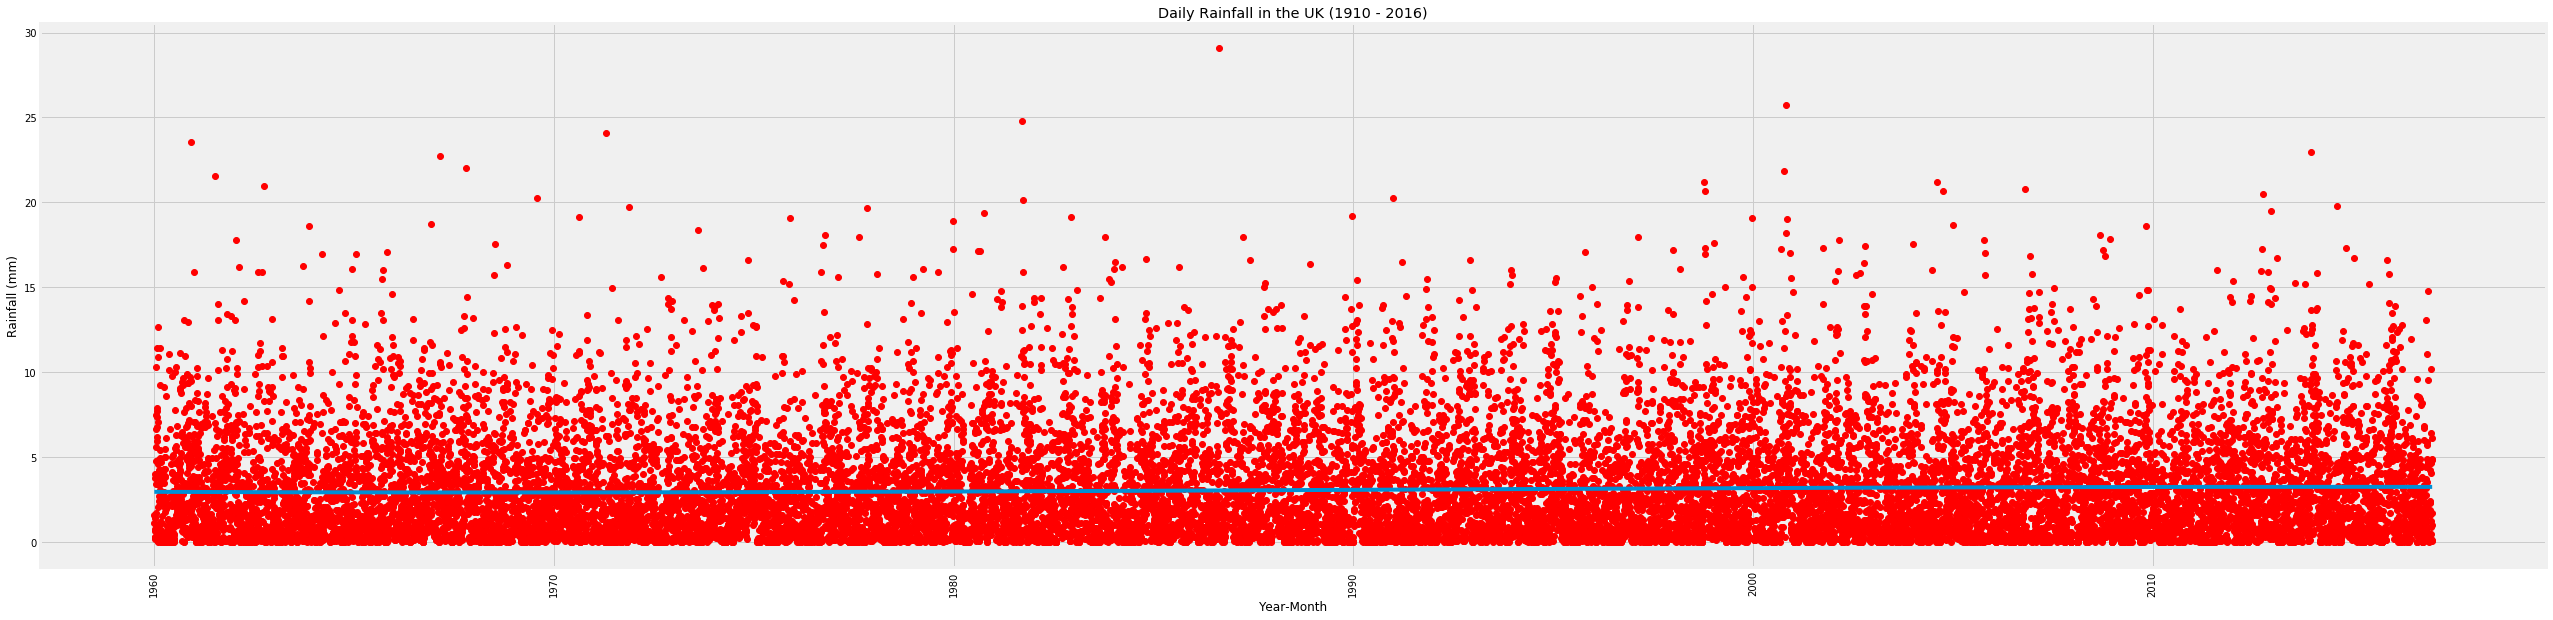

In [33]:
# BEST LINE FIT to look for any trend in data if present
y_values = finaldf['DailyMean']

#create a set of intervals equal to the number of dates
x_values = np.linspace(0,1,len(finaldf.loc[:, "DailyMean"]))
poly_degree = 3

coeffs = np.polyfit(x_values, y_values, poly_degree)
poly_eqn = np.poly1d(coeffs)
y_hat = poly_eqn(x_values)
fig = plt.figure(figsize=(40,10))
plt.xlabel('Year-Month')
plt.title('Daily Rainfall in the UK (1910 - 2016)')
plt.ylabel('Rainfall (mm)')
plt.xticks(rotation='vertical')
plt.plot(finaldf.loc[:, "YearMonth"], finaldf.loc[:,"DailyMean"], "ro")
plt.plot(finaldf.loc[:, "YearMonth"], y_hat)
y=pd.DataFrame(y_hat)
y.insert(1,'Year',finaldf['YearMonth'])
y.to_csv('SGD2.csv', index=False)
# it can be observed from the plot, the slope of best line fit is almost zero entirely
# hence it is not ideal to consider amount of rainfall as the deciding factor to prove summers will get drier

In [7]:
finaldf.head()

,YearMonth,DailyMean,Year,Month
13541,1960-01-01,1.617598,1960,1
0,1960-01-02,1.112800,1960,1
9374,1960-01-03,3.992615,1960,1
1,1960-01-04,3.757235,1960,1
5208,1960-01-05,0.796998,1960,1


In [8]:
# creating a backup(tempdf) of finaldf
tempdf = finaldf
tempdf.head()

,YearMonth,DailyMean,Year,Month
13541,1960-01-01,1.617598,1960,1
0,1960-01-02,1.112800,1960,1
9374,1960-01-03,3.992615,1960,1
1,1960-01-04,3.757235,1960,1
5208,1960-01-05,0.796998,1960,1


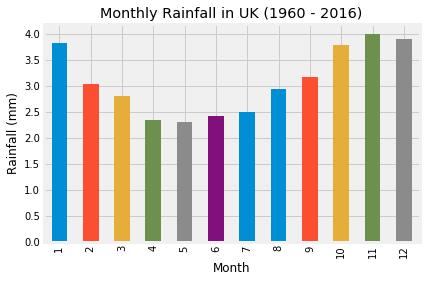

In [9]:
# plotting rainfall on monthly basis

rainfalldf = tempdf.loc[tempdf['Month'].isin(['1','2','3','4','5','6','7','8','9','10','11','12'])]
plt.xlabel('Months')
plt.title('Monthly Rainfall in UK (1960 - 2016)')
plt.ylabel('Rainfall (mm)')
rainfalldf.groupby('Month')['DailyMean'].mean().plot.bar()

# we can observe from the plot below, the rainfall during summer is lower than other seasons

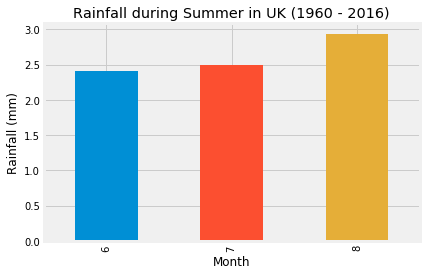

In [10]:
# plotting rainfall for months of summer (Jun=6, July=7, Aug=8)

rainfalldf = tempdf.loc[tempdf['Month'].isin(['6','7','8'])]
plt.xlabel('Months')
plt.title('Rainfall during Summer in UK (1960 - 2016)')
plt.ylabel('Rainfall (mm)')
rainfalldf.groupby('Month')['DailyMean'].mean().plot.bar()

In [11]:
# dataframe to hold number of days having rainfall less than 1 mm

daysbelowthresholdrainfall = rainfalldf.loc[(rainfalldf['DailyMean'] <= 1)]
print(daysbelowthresholdrainfall.dtypes)
print(daysbelowthresholdrainfall.tail())

YearMonth    datetime64[ns]
DailyMean           float64
Year                  int64
Month                 int64
dtype: object
       YearMonth  DailyMean  Year  Month
20682 2016-08-16   0.032474  2016      8
20683 2016-08-17   0.412337  2016      8
20692 2016-08-26   0.637870  2016      8
20695 2016-08-29   0.523728  2016      8
20697 2016-08-31   0.688387  2016      8


In [12]:
# number of days having rainfall less than 1 mm during summer grouped by year
daysbelowthresholdrainfall['DailyMean'].groupby([daysbelowthresholdrainfall.Year, daysbelowthresholdrainfall.Month]).agg('count')

Year  Month
1960  6        16
      7         4
1961  6        12
      7        15
      8         6
1962  6        16
      7        15
      8         8
1963  6        10
      7        10
      8         3
1964  6        11
      7        16
      8        12
1965  6        10
      7        11
      8        11
1966  6         8
      7        12
      8         9
1967  6        15
      7        10
      8        11
1968  6        12
      7        14
      8        12
1969  6        15
      7        10
      8        12
1970  6        16
               ..
2007  6         7
      7         4
      8        12
2008  6         8
      7        11
      8         4
2009  6        17
      7         3
      8         6
2010  6        18
      7         6
      8         7
2011  6         8
      7        15
      8         9
2012  6         5
      7         5
      8         6
2013  6        18
      7        19
      8        12
2014  6        15
      7        11
      8         

(array([711858., 715510., 719163., 722815., 726468., 730120., 733773.,
        737425.]), <a list of 8 Text xticklabel objects>)

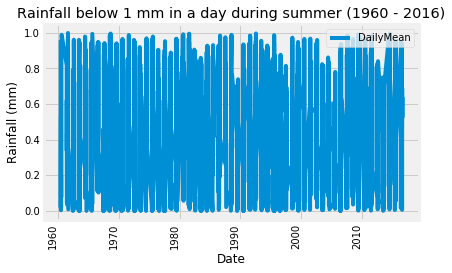

In [13]:
daysbelowthresholdrainfall.plot(x = 'YearMonth', y = 'DailyMean')
plt.title('Rainfall below 1 mm in a day during summer (1960 - 2016)')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.xticks(rotation='vertical')

# Observations: the plot shows days having rainfall recorded less than 1mm, but does not show a specific increasing or decreasing trend
# To make the plot more sensible we do the next operations

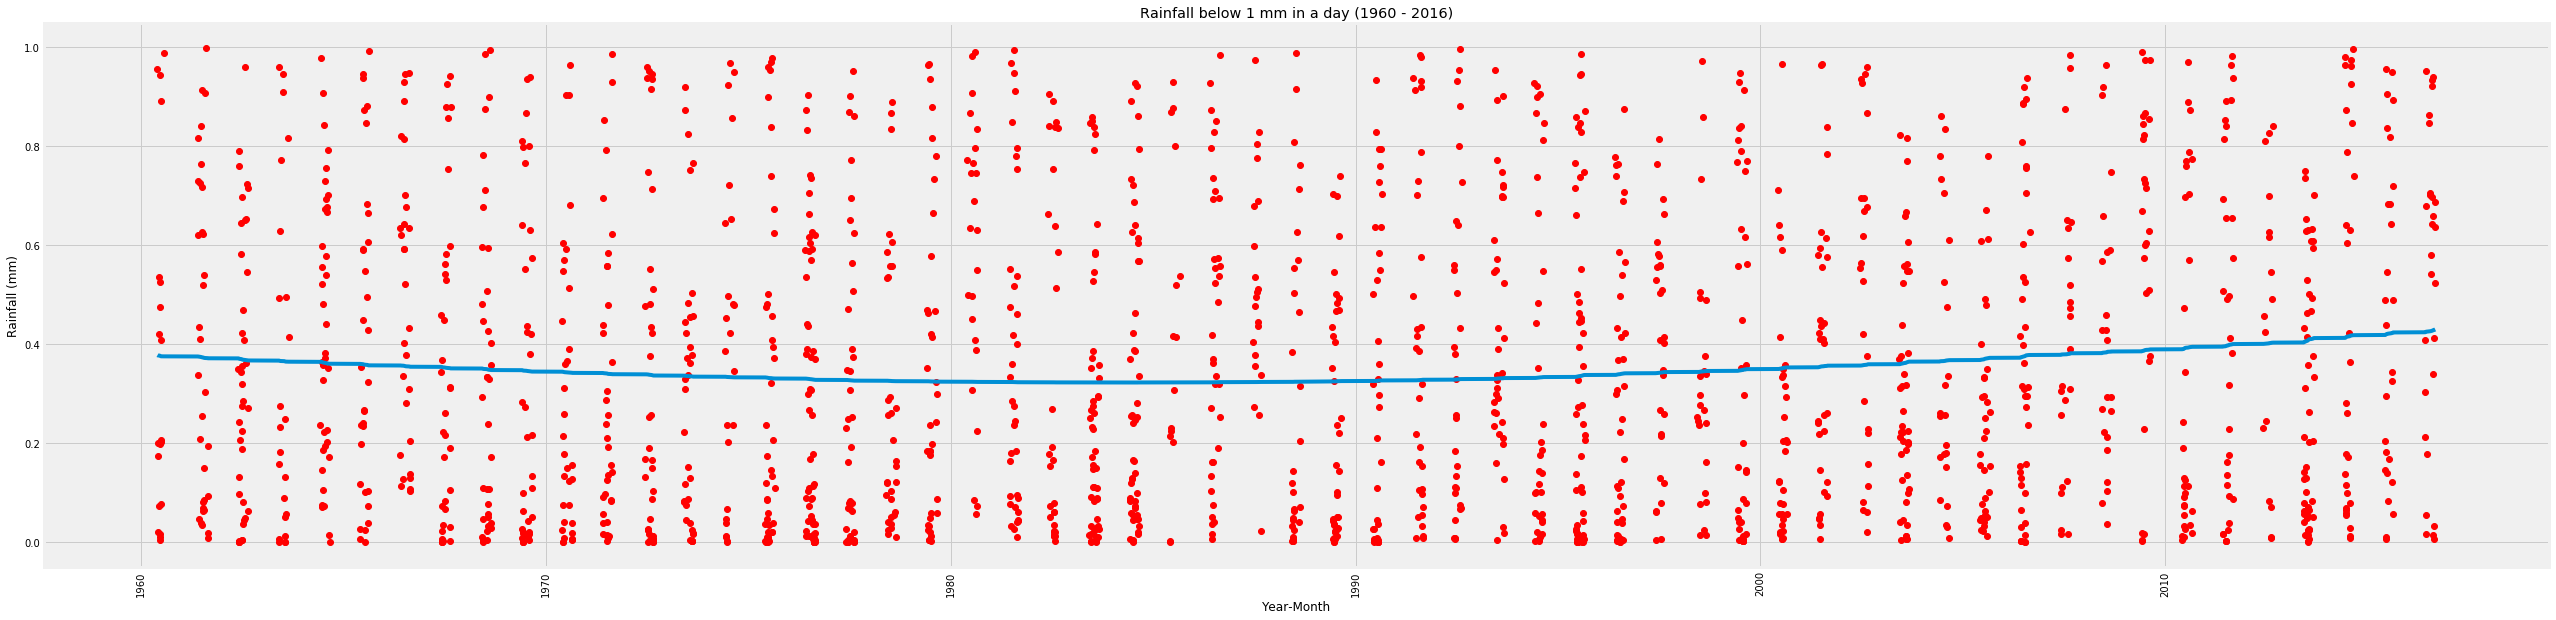

In [14]:
# BEST LINE FIT - the slope of this plot is better (increasing/decreasing) than the previous one
y_values = daysbelowthresholdrainfall['DailyMean']

#create a set of intervals equal to the number of dates
x_values = np.linspace(0,1,len(daysbelowthresholdrainfall.loc[:, "DailyMean"]))
poly_degree = 3

coeffs = np.polyfit(x_values, y_values, poly_degree)
poly_eqn = np.poly1d(coeffs)
y_hat = poly_eqn(x_values)

fig = plt.figure(figsize=(40,10))
plt.xlabel('Year-Month')
plt.title('Rainfall below 1 mm in a day (1960 - 2016)')
plt.ylabel('Rainfall (mm)')
plt.xticks(rotation='vertical')
plt.plot(daysbelowthresholdrainfall.loc[:, "YearMonth"], daysbelowthresholdrainfall.loc[:,"DailyMean"], "ro")
plt.plot(daysbelowthresholdrainfall.loc[:, "YearMonth"], y_hat)

In [15]:
# dropping redundant columns that are not required for prediction stage
daysbelowthresholdrainfall = daysbelowthresholdrainfall.drop(['Year', 'Month'], axis=1)

In [16]:
daysbelowthresholdrainfall.dtypes

YearMonth    datetime64[ns]
DailyMean           float64
dtype: object

In [17]:
# Count the number of days in a year having rainfall < 1 mm

count = daysbelowthresholdrainfall['YearMonth'].groupby([daysbelowthresholdrainfall.YearMonth.dt.year]).agg({'count'}).reset_index()
print(count.dtypes)

YearMonth    int64
count        int64
dtype: object


In [18]:
# Create a new dataframe with year and count as two columns

newdf = pd.DataFrame(count)
newdf.columns = ['Year','Number_of_days']
newdf.dtypes

Year              int64
Number_of_days    int64
dtype: object

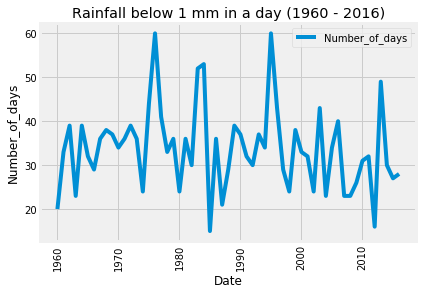

In [34]:
newdf.plot(x = 'Year', y = 'Number_of_days')
plt.title('Rainfall below 1 mm in a day (1960 - 2016)')
plt.xlabel('Date')
plt.ylabel('Number_of_days')
plt.xticks(rotation='vertical')
z=pd.DataFrame(newdf['Year'])
z.insert(1,'Data',newdf['Number_of_days'])
z.to_csv('SGD3.csv', index=False)

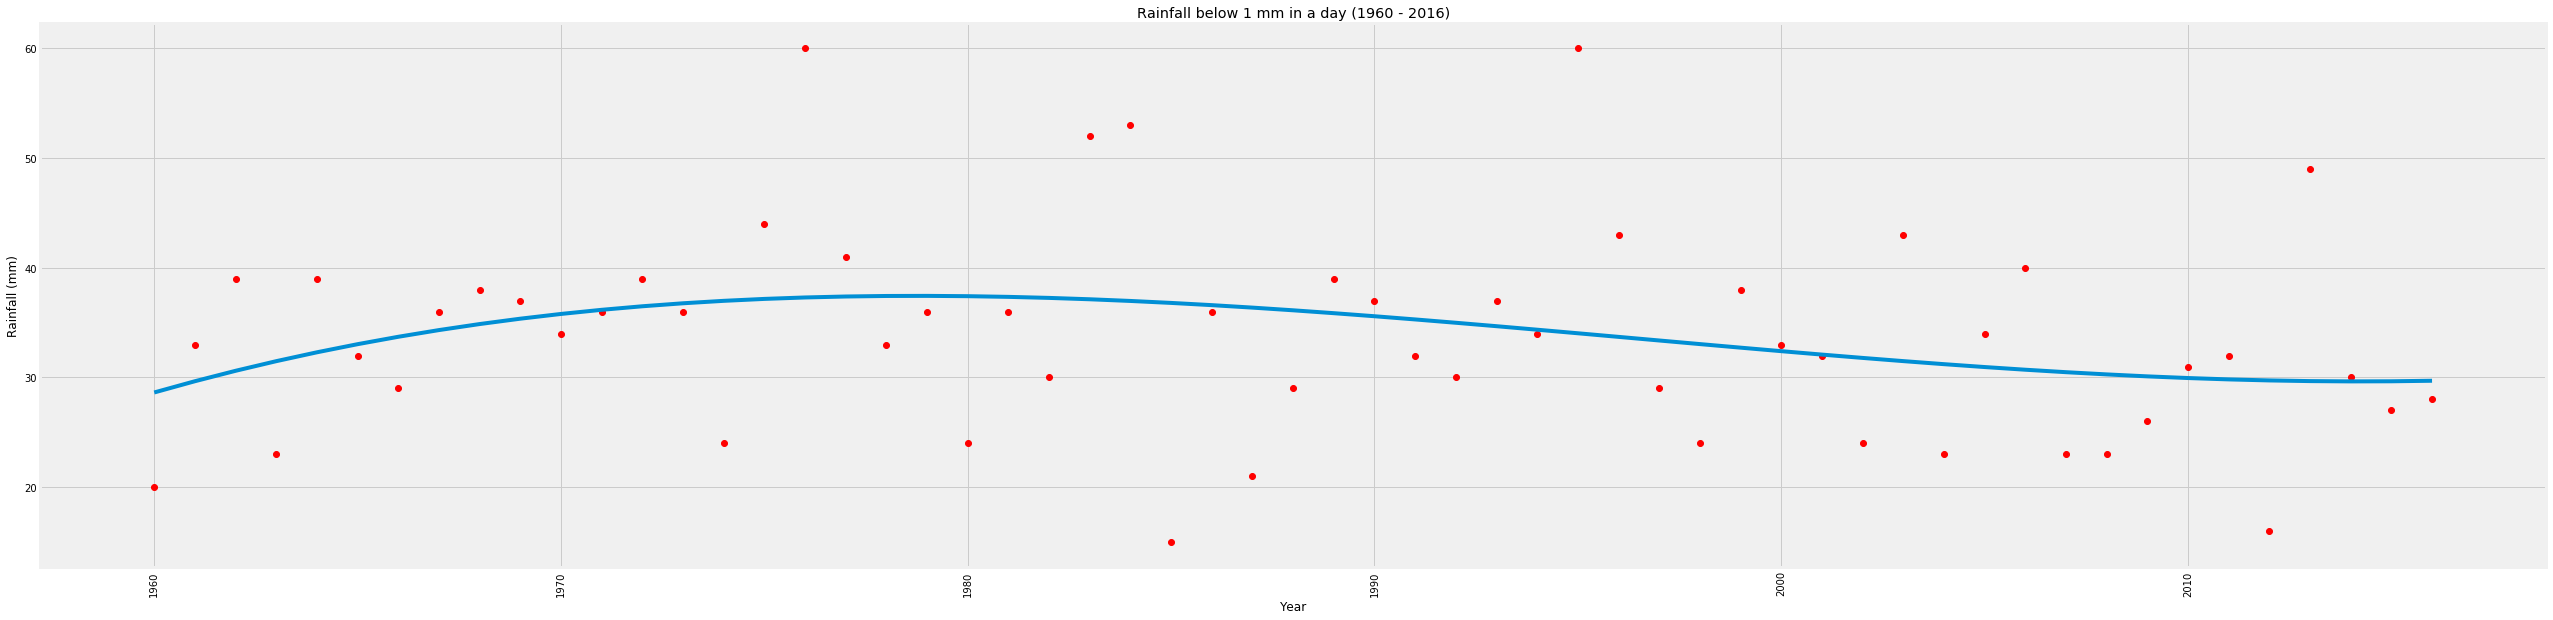

In [35]:
# BEST LINE FIT - to observe the rate of increment in trend of the above plot

y_values = newdf['Number_of_days']

#create a set of intervals equal to the number of dates
x_values = np.linspace(0,1,len(newdf.loc[:, "Number_of_days"]))
poly_degree = 3

coeffs = np.polyfit(x_values, y_values, poly_degree)
poly_eqn = np.poly1d(coeffs)
y_hat = poly_eqn(x_values)
fig = plt.figure(figsize=(40,10))
plt.xlabel('Year')
plt.title('Rainfall below 1 mm in a day (1960 - 2016)')
plt.ylabel('Rainfall (mm)')
plt.xticks(rotation='vertical')
plt.plot(newdf.loc[:, "Year"], newdf.loc[:,"Number_of_days"], "ro")
plt.plot(newdf.loc[:, "Year"], y_hat)
z=pd.DataFrame(y_hat)
z.insert(1,'Year',newdf['Year'])
z.to_csv('SGD4.csv', index=False)

In [21]:
newdf = newdf.astype({"Number_of_days": float})

In [22]:
newdf.to_csv('RainfallBelow1.csv', index=False)

In [23]:
df = pd.read_csv('RainfallBelow1.csv', index_col='Year')
df.index = pd.to_datetime(df.index, format='%Y')
print(df.head())
print(df.dtypes)

            Number_of_days
Year                      
1960-01-01            20.0
1961-01-01            33.0
1962-01-01            39.0
1963-01-01            23.0
1964-01-01            39.0
Number_of_days    float64
dtype: object


In [24]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [25]:
# goal here is to use a “grid search” to find the optimal set of parameters(p, d, q) that yields the best performance for our model.

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(df,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit()

        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:559.7935835061148
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:416.1935324465855
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:356.0293028827417
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1409.2092717553387
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:364.5127192224849
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:340.558332523056
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:261.03552150930847
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1314.145582027558
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:507.4461845231471
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:385.29903144626957
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:350.92354085780175
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1256.568441888027
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:366.4761349401769
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:335.9148352910524
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:262.88912796818863
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1203.8999450322135
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:441.5951417290263
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:355.0301824657658
ARIMA

In [26]:
# ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:245.13442269741506
# the above AIC (Akaike Information Critera) value is the lowest of all, so we should consider its corrosponding values as the optimal

# fitting the arima model

mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0010      0.197      0.005      0.996      -0.384       0.386
ma.L1         -1.0000   1245.096     -0.001      0.999   -2441.343    2439.343
ar.S.L12      -0.6037      0.173     -3.493      0.000      -0.942      -0.265
sigma2       112.2992    1.4e+05      0.001      0.999   -2.74e+05    2.74e+05


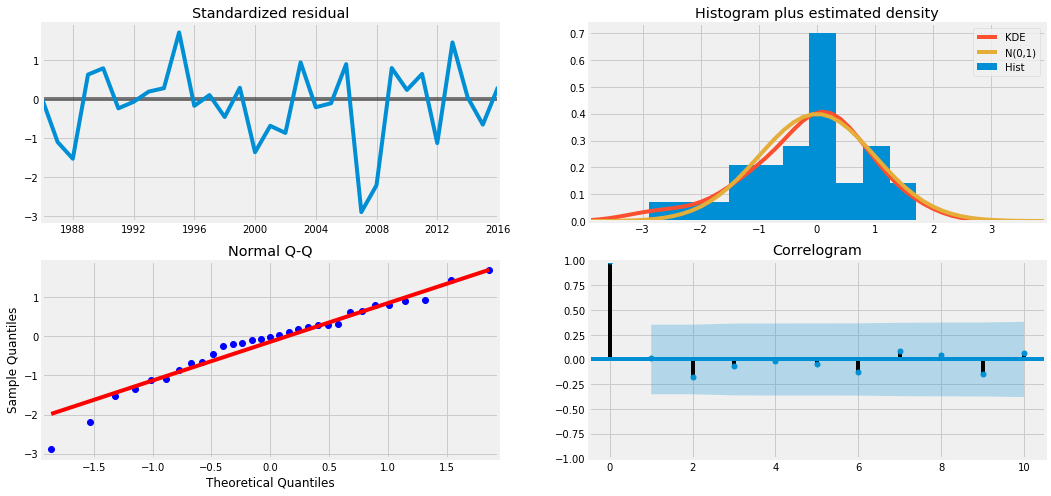

In [27]:
# model diagnostics to investigate any unusual behavior

results.plot_diagnostics(figsize=(16, 8))
plt.show()

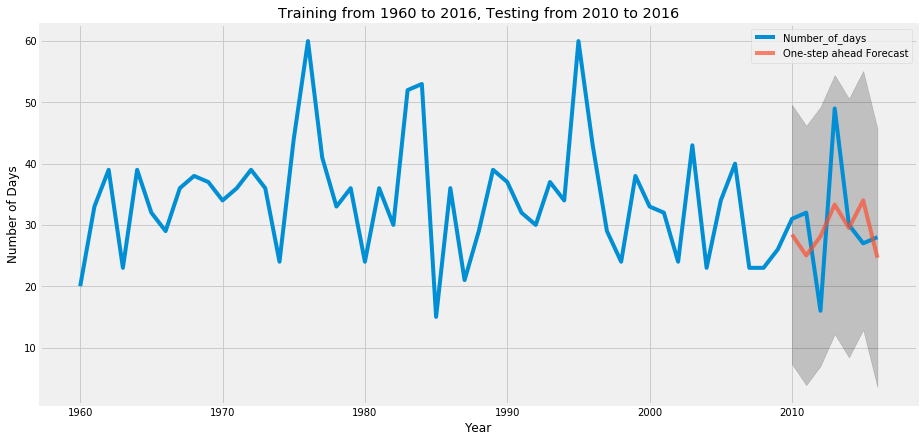

,Number_of_days
Year,
1960-01-01,20.0
1961-01-01,33.0
1962-01-01,39.0
1963-01-01,23.0
1964-01-01,39.0
1965-01-01,32.0
1966-01-01,29.0
1967-01-01,36.0
1968-01-01,38.0


In [39]:
# validating forecasts from 2010-01-01 to the end date 2016-01-01

pred = results.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['1960':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('Training from 1960 to 2016, Testing from 2010 to 2016')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Days')
plt.legend()
plt.show()
df['1960':]
# observations: the predicted plot(orange) is almost similar to the expected plot(blue)

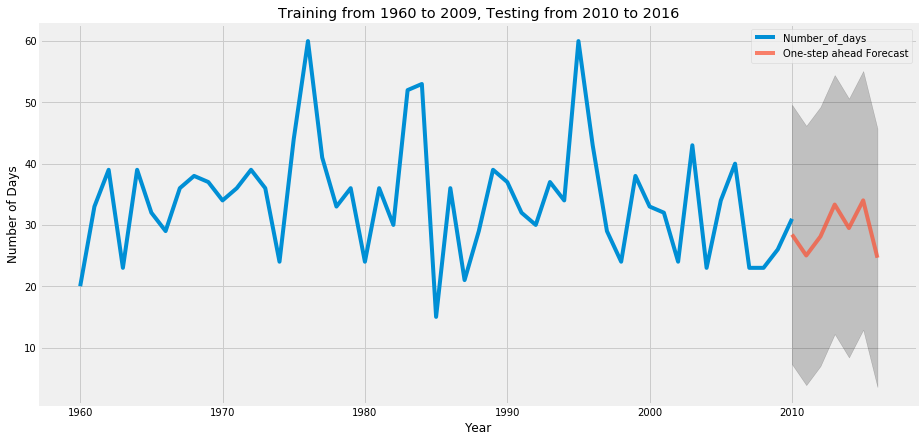

,Number_of_days
Year,
1960-01-01,20.0
1961-01-01,33.0
1962-01-01,39.0
1963-01-01,23.0
1964-01-01,39.0
1965-01-01,32.0
1966-01-01,29.0
1967-01-01,36.0
1968-01-01,38.0


In [38]:
# validating forecasts from 2010-01-01 to the end date 2016-01-01

pred = results.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['1960':'2010'].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('Training from 1960 to 2009, Testing from 2010 to 2016')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Days')
plt.legend()
plt.show()
df['1960':'2010']

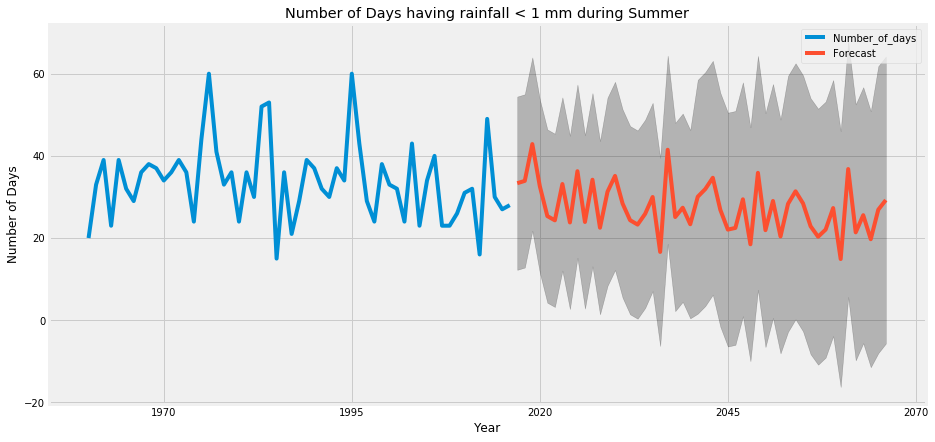

2017-01-01    33.345884
2018-01-01    33.909293
2019-01-01    42.868709
2020-01-01    32.605683
2021-01-01    25.342657
2022-01-01    24.305583
2023-01-01    33.153779
2024-01-01    23.794561
2025-01-01    36.268508
2026-01-01    23.909290
2027-01-01    34.190854
2028-01-01    22.512998
2029-01-01    31.272313
2030-01-01    35.117833
2031-01-01    28.405357
2032-01-01    24.338196
2033-01-01    23.271035
2034-01-01    25.878587
2035-01-01    29.988769
2036-01-01    16.620461
2037-01-01    41.486139
2038-01-01    25.117832
2039-01-01    27.381217
2040-01-01    23.357076
2041-01-01    30.055678
2042-01-01    31.919763
2043-01-01    34.668525
2044-01-01    26.860874
2045-01-01    22.053223
2046-01-01    22.460487
2047-01-01    29.431044
2048-01-01    18.483053
2049-01-01    35.867751
2050-01-01    21.919761
2051-01-01    29.023780
2052-01-01    20.379034
2053-01-01    28.321704
2054-01-01    31.381996
2055-01-01    28.418938
2056-01-01    22.869449
2057-01-01    20.319960
2058-01-01    22

In [40]:
# forecasting data for future 
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = df.plot(label='Observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.title('Number of Days having rainfall < 1 mm during Summer')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Days')
plt.legend()
plt.show()
pred_uc.predicted_mean
# observations: the prediction model seems to follow the learned trend and keeps on decreasing. 
# This contradicts our stated hypothesis as we were expecting number of days to increase

In [31]:
# Extract the predicted and true values of our time series
y_forecasted = pred_uc.predicted_mean
y_truth = df['2010-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# the results are NaN - why?

The Mean Squared Error of our forecasts is 2017-01-01 00:00:00   NaN
2018-01-01 00:00:00   NaN
2019-01-01 00:00:00   NaN
2020-01-01 00:00:00   NaN
2021-01-01 00:00:00   NaN
2022-01-01 00:00:00   NaN
2023-01-01 00:00:00   NaN
2024-01-01 00:00:00   NaN
2025-01-01 00:00:00   NaN
2026-01-01 00:00:00   NaN
2027-01-01 00:00:00   NaN
2028-01-01 00:00:00   NaN
2029-01-01 00:00:00   NaN
2030-01-01 00:00:00   NaN
2031-01-01 00:00:00   NaN
2032-01-01 00:00:00   NaN
2033-01-01 00:00:00   NaN
2034-01-01 00:00:00   NaN
2035-01-01 00:00:00   NaN
2036-01-01 00:00:00   NaN
2037-01-01 00:00:00   NaN
2038-01-01 00:00:00   NaN
2039-01-01 00:00:00   NaN
2040-01-01 00:00:00   NaN
2041-01-01 00:00:00   NaN
2042-01-01 00:00:00   NaN
2043-01-01 00:00:00   NaN
2044-01-01 00:00:00   NaN
2045-01-01 00:00:00   NaN
2046-01-01 00:00:00   NaN
2047-01-01 00:00:00   NaN
2048-01-01 00:00:00   NaN
2049-01-01 00:00:00   NaN
2050-01-01 00:00:00   NaN
2051-01-01 00:00:00   NaN
2052-01-01 00:00:00   NaN
2053-01-01 00:00:00  